# Séance 4 : descripteurs d'image

Cette dernière séance s'intéresse aux possibilités de reconnaître des objets dans une image ou de trouver des images similaires à une image requête. Comme pour l'alignement d'images à partir de points d'intérêt, nous allons pour ce faire utiliser des **descripteurs**. Ces descripteurs ne porteront toutefois pas sur un point d'intérêt précis mais sur l'image entière.

# Template matching

Le *template matching* consiste à localiser un objet, décrit par un modèle (*template*) dans une image. En pratique, on aura donc l'image d'un modèle $T$ de dimensions $w \times h$ et une image $I$ de dimensions $W \times H$ dans laquelle effectuer la recherche.

La méthode classique consiste à chercher la position $(x^*,y^*)$ idéale dans l'image qui minimise la distance entre la fenêtre de taille $w \times h$ centrée en $(x,y)$ et le *template*:

$$x^*, y^* = \arg\min_{x,y} E(x,y) = \arg\min \sum_{i=1}^w \sum_{j=1}^h \left( I[x+i,y+j] - T[i, j] \right)^2$$

Cette recherche est équivalente à chercher la position $(x^*,y^*)$ qui maximise la **corrélation croisée** entre la fenêtre considérée et le *template*:

$$x^*, y^* = \arg\max_{x,y} \sum_{i=1}^w \sum_{j=1}^h I[x+i,y+j] \cdot T[i,j] = \arg\max_{x,y} F^{(x,y)} \star T$$

où $F^{(x,y)}$ est la fenêtre centrée en $(x,y)$.

Pour trouver la position la plus probable du *template* dans l'image, on peut donc procéder à l'aide de l'algorithme suivant :
1. calculer la corrélation croisée pour toutes les positions $(x,y)$
2. renvoyer les valeurs $(x^*, y^*)$ pour lesquelles la corrélation est maximale

## À la main

Mettons cette logique en application sur un exemple. Pour simplifier les choses, nous allons travailler en niveaux de gris mais on aurait pu tout aussi bien définir la corrélation croisée en sommant la corrélation pour les canaux rouge, bleu et vert.

Les images avec lesquelles nous allons faire nos tests sont des captures d'écran de Pokémon Rouge, sorti en France en 1999 sur Game Boy .

In [ ]:
import skimage
import matplotlib.pyplot as plt
from skimage import io

template = io.imread("images/pokeball.png", as_gray=True)
image = io.imread("images/pokemon_safari.jpg", as_gray=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [2.5, 1]})
axes[0].imshow(image, cmap="gray") and axes[0].set_title("Image où chercher l'objet")
axes[1].imshow(template, cmap="gray") and axes[1].set_title("Template") and plt.show()

Remarquons que les dimensions du *template* correspondent à la dimension de l'objet dans l'image.

Nous pourrions calculer la corrélation manuellement en utilisant la formule précédemment détaillée mais ce n'est pas particulièrement intéressant. Utilisons plutôt SciPy pour le faire grâce à la fonction `scipy.signal.correlate2d`. Celle-ci calcule la corrélation croisée entre deux matrices 2D (par exemple, des images en niveaux de gris).

In [ ]:
from scipy.signal import correlate2d

correlation_map = correlate2d(image, template, mode="same")
# Affichons la carte de corrélation
fig = plt.figure(figsize=(10, 8))
plt.imshow(correlation_map, cmap="magma")
plt.colorbar(shrink=0.5)
plt.title("Carte de corrélation croisée")
plt.show()

Oups. Le résultat obtenu n'est pas tout à fait ce que l'on escomptait. En effet, dans la corrélation croisée, les pixels brillants sont très favorisés. Toutes les zones de terrain blanc apparaissent donc avec une forte corrélation, plus forte même que la position réelle de l'objet.

L'astuce consiste donc à ne pas considérer le template tel quel mais à lui retirer sa valeur moyenne, de sorte à débiaiser les résultats :

In [ ]:
template -= template.mean()

In [ ]:
correlation_map = correlate2d(image, template, mode="same")
# Affichons la carte de corrélation
fig = plt.figure(figsize=(10, 8))
plt.imshow(correlation_map, cmap="magma")
plt.colorbar(shrink=0.5)
plt.title("Carte de corrélation croisée")
plt.show()

C'est nettement mieux ! On peut maintenant utiliser un peu de magie avec NumPy pour extraire les coordonnées du maximum (le pixel le plus brillant dans la carte de corrélation croisée) :

In [ ]:
import numpy as np
# y, x sont inversés entre NumPy et Matplotlib
y_max, x_max = np.argwhere(correlation_map == correlation_map.max())[0]
# On affiche la carte avec le point correspondant au maximum
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes[0].imshow(correlation_map, cmap="magma")
axes[0].plot(x_max, y_max, "w*", markersize=10)
axes[0].set_title("Carte de corrélation croisée")

axes[1].imshow(image, cmap="gray")
w, h = template.shape
rect = plt.Rectangle((x_max - w//2, y_max - h//2), w, h, edgecolor="r", facecolor="none")
axes[1].add_patch(rect)
axes[1].set_title("Détection dans l'image")
plt.show()

À noter que cette technique est plutôt robuste au bruit et aux imperfections. On peut aussi bien l'utiliser sur une image dégradée qu'avec un template approximatif. Appliquons par exemple un bruit gaussien :

In [ ]:
from skimage.util import random_noise
noisy = random_noise(image, mode="gaussian", var=0.5)
correlation_map = correlate2d(noisy, template, mode="same")
y_max, x_max = np.argwhere(correlation_map == correlation_map.max())[0]

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes[0].imshow(correlation_map, cmap="magma")
axes[0].plot(x_max, y_max, "w*", markersize=10)
axes[0].set_title("Carte de corrélation croisée")
axes[1].imshow(noisy, cmap="gray")
w, h = template.shape
rect = plt.Rectangle((x_max - w//2, y_max - h//2), w, h, edgecolor="r", facecolor="none")
axes[1].add_patch(rect)
axes[1].set_title("Détection dans l'image")
plt.show()

### Détections multiples

L'algorithme précédent fonctionne bien mais le fait de ne considérer que la valeur maximale fait que l'on peut potentiellement rater la présence de plusieurs objets correspondants au *template*. Prenons l'image suivante :

In [ ]:
image2 = io.imread("images/pokemon_choice.png", as_gray=True)
plt.imshow(image2, cmap="gray") and plt.show()

Que faire dans cette situation ? L'objet correspondant au *template* s'y trouve à trois reprises. On aimerait donc pouvoir détecter ces trois occurrences mais rien ne dit que la corrélation sera strictement égale au maximum pour les trois en simultanée. Une solution est donc de ne pas considérer la corrélation maximale mais de considérer les corrélations « presque maximales », par exemple entre 95% et 100% de la valeur maximale.

On remarque par ailleurs que les objets sont plus petits dans cette image, il faut donc redimensionner le *template* (on verra plus tard comment s'en tirer quand on ne connaît pas la taille des objets que l'on cherche) :

In [ ]:
from skimage.transform import rescale
small_template = rescale(template, scale=0.5)
w, h = small_template.shape

correlation_map = correlate2d(image2, small_template, mode="same")
tolerance = 0.95 # on cherche les maxima au-delà d'un seuil de 95%

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].imshow(correlation_map) and axes[0].set_title("Corrélations croisées")
axes[1].imshow(image2, cmap="gray") and axes[1].set_title("Détection dans l'image")
for y_max, x_max in np.argwhere(correlation_map > tolerance * correlation_map.max()):
    axes[0].plot(x_max, y_max, "w*", markersize=12)
    rect = plt.Rectangle((x_max - w//2, y_max - h//2), w, h, edgecolor="r", facecolor="none")
    axes[1].add_patch(rect)
plt.show()

Et le tour est joué ! Essayez d'abaisser ou d'augmenter le seuil de tolérance pour voir l'impact que cela peut avoir sur les détections dans l'image.

### Détections à plusieurs échelles

Comme nous venons de le voir, une limite du *template matching* est que l'on a besoin de connaître au préalable la taille de l'objet dans l'image pour savoir à quelle échelle redimensionner notre *template*. C'est assez gênant car en général, on ne peut pas vraiment faire d'hypothèse : si l'objet est plus loin de l'appareil photo, il apparaîtra de la même façon mais plus petit.

Une solution de contournement consiste à tester le *template* à plusieurs échelles. Pour ce faire, une possibilité est de redimensionner le *template* pour réduire sa taille :

In [ ]:
# les échelles de "zoom" à tester : 25%, 50%, 75% et 100%
scales = [0.25, 0.5, 0.75, 1.0]
tolerance = 0.95

fig, ax = plt.subplots(ncols=len(scales), nrows=1, figsize=(16, 6))
for idx, scale in enumerate(scales):
    scaled_template = rescale(template, scale)
    correlation_map = correlate2d(image2, scaled_template, mode="same")
    ax[idx].imshow(correlation_map)
    for y_max, x_max in np.argwhere(correlation_map > tolerance * correlation_map.max()):
        ax[idx].plot(x_max, y_max, "w*", markersize=12)
    ax[idx].set_title(f"Échelle = {scale},\n corrélation max. = {correlation_map.max():.1f}")
plt.show()

*Note* : Pour agrandir le *template*, on va plutôt faire l'opposé et réduire la taille de l'image (la corrélation croisée est plus rapide dans ce sens).

Maintenant que l'on a effectué le *template matching* à plusieurs échelles, on se retrouve avec plein de détections sur les bras. Mais comment peut-on décider quelle échelle est la plus pertinente pour nous ?

**Question** : comment évoluent les corrélations maximales quand on augmente les dimensions du *template* ? Pourquoi ?

Une solution à ce problème consiste à *normaliser* la corrélation croisée en divisant par la taille du *template*:
    
$$x^*, y^* = \arg\max_{x,y} \frac{1}{wh} \sum_{i=1}^w \sum_{j=1}^h I[x+i,y+j] \cdot T[i,j] = \arg\max_{x,y} \frac{1}{wh} F^{(x,y)} \star T$$
    

En Python, cela donne :

In [ ]:
# les échelles de "zoom" à tester : 25%, 50%, 75% et 100%
scales = [0.25, 0.5, 0.75, 1.0]
tolerance = 0.95

fig, ax = plt.subplots(ncols=len(scales), nrows=1, figsize=(16, 6))
for idx, scale in enumerate(scales):
    scaled_template = rescale(template, scale)
    correlation_map = correlate2d(image2, scaled_template, mode="same")
    # Normalisation ->
    correlation_map /= scaled_template.size
    ax[idx].imshow(correlation_map)
    for y_max, x_max in np.argwhere(correlation_map > tolerance * correlation_map.max()):
        ax[idx].plot(x_max, y_max, "w*", markersize=12)
    ax[idx].set_title(f"Échelle = {scale},\n corrélation max. = {correlation_map.max():.1f}")
plt.show()

On peut alors considérer les détections avec les corrélation croisées les plus hautes pour toutes les échelles. Cela permet même de détecter des objets de différentes taille dans une seule image.

## Avec scikit-image

Vous avez l'habitude, `scikit-image` fait tout le boulot pour nous. Il suffit d'aller chercher la fonction appropriée dans le bon sous-module. En l'occurrence, il s'agit de `skimage.feature.match_template`, qui implémente une version efficace de l'algorithme présenté ci-dessus.

In [ ]:
from skimage.feature import match_template

result = match_template(image, template, pad_input=True)
y, x = np.unravel_index(np.argmax(result), result.shape)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 3, 3]})
ax[0].imshow(template, cmap=plt.cm.gray) and ax[0].set_title('Template')
ax[0].set_axis_off()

ax[1].imshow(image, cmap=plt.cm.gray) and ax[1].set_title('Image')
ax[1].set_axis_off()
h, w = template.shape
rect = plt.Rectangle((x-w//2, y-h//2), w, h, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(result) and ax[2].set_title('Résultat de match_template')
ax[2].set_axis_off()
ax[2].autoscale(False)
ax[2].plot(x, y, 'w*', markersize=15)

plt.show()

Cet algorithme fonctionne bien entendu de la même façon sur des images en couleur :

In [ ]:
airport = io.imread("images/orly_gmaps.jpg")
plane = io.imread("images/avion.jpg")
result = match_template(airport, plane, pad_input=True)
h, w, _ = plane.shape
tolerance = 0.7

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 3, 3]})
ax[0].imshow(plane, cmap=plt.cm.gray) and ax[0].set_title('Template')
ax[0].set_axis_off()
ax[1].imshow(airport, cmap=plt.cm.gray) and ax[1].set_title('Image')
ax[1].set_axis_off()
ax[2].imshow(skimage.exposure.rescale_intensity(result, out_range=np.uint8))
ax[2].set_axis_off()
ax[2].set_title('Résultat de match_template')
ax[2].autoscale(False)
for y, x, _ in np.argwhere(result > tolerance * result.max()):
    rect = plt.Rectangle((x-w//2, y-h//2), w, h, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    ax[2].plot(x, y, 'w*', markersize=15)
plt.show()

On voit tout de même apparaître quelques limitations du *template matching*:
- pas d'invariance à la rotation (il faudrait tester le *template* selon différentes orientations et pour espérer détecter des avions positionnés différemment),
- détections multiples d'un même objet (un algorithme de *non-maximal suppression* (NMS) peut résoudre ce problème),
- sensible à des variations légères d'apparence.

# Descripteurs d'image

## Histogrammes de couleur

Du point de vue perceptuel, une image est avant tout caractérisée par les couleurs qui la composent. Une façon de « résumer » rapidement le contenu d'une image est donc de lister les couleurs qui y apparaissent et le nombre de fois que chaque couleur apparaît dans un pixel. Ces valeurs sont représentées par les **histogrammes de couleur**.

In [ ]:
import skimage
from skimage.exposure import histogram

cat = skimage.data.cat()

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.imshow(cat)
fig.add_subplot(122)
for idx, col in enumerate(["Rouge", "Vert", "Bleu"]):
    hist, hist_centers = histogram(cat[:,:,idx], normalize=True)
    plt.bar(hist_centers, hist, alpha=0.5, label=col)
plt.legend()
plt.show()

L'image est ainsi décrite par la combinaison des 3 histogrammes :
$$\mathbf{v} = h_\text{rouge}::h_\text{vert}::h_\text{bleu}$$

où $::$ désigne la concaténation de vecteurs. Pour des histogrammes complets à 256 couleurs, cela réduit donc une image de dimensions $W \times H$ à un vecteur de $3 \times 256 = 768$ valeurs. Cela permet ainsi de faire une recherche d'images : pour une image requête $I_r$, je peux trouver l'image de ma base de données $\{I_1, I_2, \ldots, I_n\}$ qui a le profil colorimétrique le plus proche.

Voyons un exemple sur une recherche de logo :

In [ ]:
database = [io.imread(f"images/wow{idx}.jpg") for idx in range (5)]
print("Base de données :")
fig, axes = plt.subplots(nrows=1, ncols=len(database), figsize=(16, 6))
for img, ax in zip(database, axes):
    ax.imshow(img) and ax.axis("off")
plt.show()

query = io.imread("images/wow_petit.jpg")
plt.imshow(query) and plt.axis("off")
plt.title("Image requête")
plt.show()

À l'aide de la fonction suivante, on peut calculer les histogrammes pour toutes les images de la base de données ainsi que pour l'image requête : 

In [ ]:
def color_histogram(image):
    hists = [histogram(image[:,:,idx], normalize=True)[0][1:-1] for idx in range(3)]
    return np.concatenate(hists)
                       
db_hists = [color_histogram(img) for img in database]
query_hist = color_histogram(query)

On calcule les scores (ici on utilise la distance euclidienne mais pour les histogrammes, il serait préférable d'utiliser la [divergence de Kullback-Leibler](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) qui est nettement plus adaptée) :

In [ ]:
scores = [np.linalg.norm(db_hist - query_hist) for db_hist in db_hists]

Il ne reste plus qu'à trouver et afficher l'image pour laquelle le score est le plus faible :

In [ ]:
# on trouve l'image pour laquelle le score est le minimum
closest_idx = np.argmin(scores)

fig, axes = plt.subplots(nrows=1, ncols=len(database), figsize=(16, 6))
for img, ax, score in zip(database, axes, scores):
    ax.imshow(img)
    ax.set_title(f"Distance: {score:.3f}")
    ax.axis("off")
plt.show()

plt.imshow(database[closest_idx])
plt.title("Image la plus proche de la requête")
plt.axis("off")
plt.show()

L'inconvénient de ce descripteur, c'est qu'il ignore complètement la structure de l'image. On peut mélanger les pixels et obtenir exactement le même histogramme. Pour l'image de Chelsea le chat, cela donne :

In [ ]:
shuffle = np.reshape(cat, (-1, cat.shape[2]))
np.random.shuffle(shuffle)
shuffle = np.reshape(shuffle, cat.shape)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.imshow(shuffle) and plt.title("Image mélangée")
fig.add_subplot(122)
for idx, col in enumerate(["Rouge", "Vert", "Bleu"]):
    hist, hist_centers = histogram(shuffle[:,:,idx])
    plt.bar(hist_centers, hist, alpha=0.5, label=col)
plt.legend()
plt.show()

Ce qui est exactement le même histogramme que précédemment. Autrement dit, ce descripteur ne comporte que de l'information concernant couleur mais pas du tout concernant la structure spatiale de l'image. On va donc s'intéresser à deux autres types de descripteurs qui prennent en compte l'organisation d'une image, c'est-à-dire :
- la texture (les structures haute fréquence),
- et la forme (les structures basse fréquence).

*Note* : les histogrammes de couleur que l'on a calculé ne sont pas tout fait des histogrammes de couleur 3D. Ce sont plutôt des triples histogrammes d'intensité RVB. Le problème fondamental ne change pas.

## Descripteurs de forme : histogrammes de gradients orientés

Les histogrammes de gradients orientés (HOG) sont des descripteurs d'image particulièrement populaires pour la détection d'objets. Ils ont été proposés par [Dalal et Triggs en 2005](http://ieeexplore.ieee.org/document/1467360/) notamment pour détecter des piétons dans des images.

L'algorithme fonctionne en quatre temps :
1. calculer les gradients de l'image selon $x$ et $y$
2. calculer les histogrammes des intensités des gradients pour chaque orientation
3. normaliser les histogrammes dans un bloc
4. concaténer les histogrammes en un vecteur de caractéristique

L'étape 1 se fait de la façon habituelle (filtre de Prewitt) et permet de calculer la norme et l'orientation des gradients. Pour une image couleur, on utilise le gradient de la couleur qui est le plus intense localement (ce qui permet d'être invariant à un changement de couleur).

L'étape 2 divise l'image en cellules (*cells*) sur lesquelles calculer l'histogramme. Pour chaque cellule on calcule l'histogramme des intensités des gradients selon $k$ orientations (par exemple, $k=4$ pour considérer les orientations à 90° haut/bas/gauche/droite, $k=8$ pour aussi considérer les diagonales). Cela produit pour chaque cellules autant d'histogrammes que d'orientation. 

L'étape 3 considère un bloc, c'est-à-dire un ensemble de $(c_x, c_y)$ cellules. Pour un bloc, on normalise les histogrammes des cellules de ce bloc en divisant par la norme euclidienne de l'histogramme global du bloc.

L'étape 4 collecte les histogrammes des cellules de tous les blocs et les concatène. Une cellule peut appartenir à plusieurs blocs, auquel cas son histogramme apparaît donc plusieurs fois dans la caractéristique finale (mais avec des normalisations différentes).

Voyons ce que cela donne sur un exemple :

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

image = data.astronaut()

descriptor, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

Ici, le paramètre `visualize=True` permet d'obtenir la visualisation à droite. En général, on se contente du descripteur :

In [ ]:
descriptor.shape

L'image $512\times512$ devient donc décrite par un vecteur de taille $8192$ qui contient (on l'espère) toutes les informations utiles concernant la forme des objets contenus dans l'image. 

# Applications des descripteurs : reconnaissance d'image

Une fois les descripteurs d'image obtenus, leur principal intérêt est de pouvoir reconnaître automatiquement le contenu d'une image ou de retrouver une image similaire (comme nous l'avons fait avec les histogrammes de couleurs). La reconnaissance d'objet à partir des descripteurs ou des caractéristiques extraites de l'image passe généralement par des algorithmes d'apprentissage automatique (*machine learning*), ce qui sort du cadre de ce cours.

Néanmoins, on peut évoquer l'algorithme le plus simple : la classification par $k$ plus proches voisins.

## k-nearest neighbors classification

Imaginons une collection de $n$ images $I_1, I_2, \dots, I_n$. Ces images sont réparties dans $p$ groupes (par exemple, les images de chat, de chien, de raton-laveur, etc.) que l'on représente par une étiquette $y_i$ (un entier).

Grâce aux descripteurs $v_1, v_2, \dots, v_n$ calculés sur les images, on peut calculer une distance entre chaque paire d'images, définie par :
$$d(I_i, I_j) = \| v_i - v_j \|$$

À partir de là, admettons que nous recevons une nouvelle image $I_{n+1}$ dont **on ne connaît pas le groupe**. On aimerait savoir quel animal est représenté dans cette image. Pour ce faire, on peut aller rechercher dans la banque d'exemples les $k$ images les plus proches (au sens de la distance $d$) de $I_{n+1}$. On rassemble ensuite les $k$ étiquettes correspondantes et, par un vote majoritaire, on décide que l'étiquette $y_{n+1}$ doit être l'étiquette majoritaire parmi les $k$ voisins trouvés.

Commençons par charger nos collections d'images. On les redimensionne en (512, 512) pour plus de simplicité. Nous avons ici deux groupes : les images de voiture et les images de vélo.

In [ ]:
from skimage.transform import resize

size = 256

bikes = [resize(io.imread(f"images/velo{idx}.jpg"), (size, size)) for idx in range(1,6)]
cars = [resize(io.imread(f"images/voiture{idx}.jpg"), (size, size)) for idx in range(1,6)]
images = bikes + cars

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(bikes[0]) and axes[0].axis('off')
axes[1].imshow(cars[0]) and axes[1].axis('off')
plt.show()

Calculons les descripteurs HOG pour toutes ces images :

In [ ]:
bikes_hog = [hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), channel_axis=2) for img in bikes]
cars_hog = [hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), channel_axis=2) for img in cars]

# étiquettes (1 pour les vélos, 2 pour les voitures)
bikes_labels = 1 * np.ones((len(bikes_hog), ))
cars_labels = 2 * np.ones((len(cars_hog), ))

On créé la base de données :

In [ ]:
dataset = np.concatenate((bikes_hog, cars_hog))
labels = np.concatenate((bikes_labels, cars_labels)).astype("int")

Chargeons une nouvelle image. On la redimensionne en (256, 256), on calcule ses HOG puis on calcule les scores pour chaque image de la base de données avant de trier les images par distance croissante :

In [ ]:
query = resize(io.imread("images/velo6.jpg"), (size, size))
plt.imshow(query) and plt.show()

hog_query = hog(query, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), channel_axis=2)
scores = np.array([np.linalg.norm(hog_query - hog) for hog in dataset])

Les images les plus proches sont les suivantes : 

In [ ]:
closest = np.argsort(scores)
print(closest)
fig, axes = plt.subplots(nrows=1, ncols=len(closest), figsize=(20, 8))
for idx, img_idx in enumerate(closest):
    axes[idx].imshow(images[img_idx]) and axes[idx].axis('off')

On peut conserver seulement les $k$ plus proches, par exemple $k=3$. On cherche alors l'étiquette majoritaire des les étiquettes des images les plus similaires à la requête :

In [ ]:
k = 3
closest_labels = labels[closest[:k]]
print(f"Étiquettes des {k} images les plus proches : {closest_labels}")
print(f"Étiquette majoritaire : {np.argmax(np.bincount(closest_labels))}")

Vous pouvez tester avec l'image `"voiture6.jpg"` pour un autre exemple.

## Détection de visage : méthode de Viola et Jones

Pour terminer, parlons d'une application très courante lorsque l'on cherche à construire un outil interactif : la détection de visage. La méthode la plus populaire est celle introduite en 2004 par [Viola et Jones](https://www.merl.com/publications/docs/TR2004-043.pdf).

Pour détecter rapidement des visages, Viola et Jones proposent des caractéristiques rapides à calculer : les caractéristiques pseudo-Haar.

Dans une fenêtre rectangulaire, ces caractéristiques vont calculer la différences des sommes des pixels contenus dans les régions blanches et dans les régions noires. Les régions sont rectangulaires et peuvent être définies de différentes façons :
![image.png](attachment:image.png)

Par exemple pour (1), la caractéristique est obtenue en calculant :
- la somme des pixels dans la partie blanche à gauche,
- la somme des pixels dans la partie noire à droite,
- la différence entre la somme « noire » et la somme « blanche ».

Viola et Jones utilisent toutes les combinaisons pour construire un ensemble de caractéristiques.

Pour pouvoir calculer plus rapidement ces caractéristiques, Viola et Jones proposent d'utiliser l'image intégrale, définie par :

$$II[x,y] = \sum_{x'\leq x, y' \leq y} I[x', y']$$

c'est-à-dire que le pixel $(x,y)$ de l'image intégrale est obtenu en sommant tous les pixels au-dessus de lui et à sa gauche dans l'image initiale. En utilisant l'image intégrale, le calcul des caractéristiques de pseudo-Haar se fait en temps constant.

En pratique, les caractéristiques sont calculées à toutes les positions et à toutes les échelles pour une fenêtre de détection (par exemple $24\times 24$). Cela donne de très nombreuses caractéristiques (plusieurs dizaines de milliers). Celles-ci sont ensuite traitées par *machine learning* pour décider si la fenêtre de détection contient un visage ou pas.

On ne détaille pas la partie ML de l'algorithme mais, grossièrement, la méthode de Viola et Jones va passer chaque fenêtre de détection dans une cascade de 3 classifieurs. Le premier classifieur (étage 1) est rapide mais peu précis (il dit souvent oui), le deuxième classifieur (étage 2) est un peu moins rapide mais plus précis et le classifier final (étage 3) est moins rapide mais le plus performant. Cela permet de rapidement éjecter (en peu de calculs) les fenêtres sans visage.

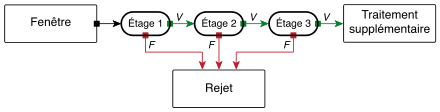

Concrètement la méthode de Viola et Jones est une méthode de recherche exhaustive : on va tester toutes les fenêtres possibles de l'image à toutes les échelles (dans une pyramide, comme pour ORB). Cette exhaustivité est possible car le calcul des caractéristiques de pseudo-Haar est très rapide et le rejet des (nombreuses et largement majoritaires) fenêtres négatives (sans visage) se fait de façon efficace.

Une version préentraînée de la méthode de Viola et Jones pour la détection de visages est disponible dans `scikit-image` : 

In [ ]:
from skimage.feature import Cascade

# Charge le fichier contenant le modèle préentraîné
trained = skimage.data.lbp_frontal_face_cascade_filename()

# Détecteur
detector = Cascade(trained)

image = data.astronaut()

detected = detector.detect_multi_scale(image,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(60,60),
                                       max_size=(120, 120))

Les paramètres importants du détecteur sont :
- `scale_factor` : facteur d'échelle de la pyramide d'images,
- `step_ratio` : facteur par lequel est multiplié le pas de la recherche exhaustive à chaque échelle. 1 correspond à une recherche exhaustive. En général, entre 1 et 1,5.
- `min_size` : la taille minimale de visage à détecter,
- `max_size` : la taille maximale de visage à détecter.

Les résultats de la détection donnent :
- `r` : la ligne du coin en haut à gauche du rectangle qui englobe le visage,
- `c` : idem mais pour la colonne,
- `width`/`height`: la largeur et la hauteur du rectangle.

In [ ]:
print(detected)

On peut dessiner avec `matplotlib` le rectangle :

In [ ]:
from matplotlib import patches
fig, ax = plt.subplots()
plt.imshow(image, cmap="gray")

for patch in detected:
    ax.add_patch(
        patches.Rectangle(
            (patch['c'], patch['r']),
            patch['width'],
            patch['height'],
            fill=False,
            color='r',
            linewidth=2
        )
    )

plt.show()

### À vous de jouer !

Essayez ces algorithmes avec vos propres images. Notamment, essayez d'appliquer des déformations géométriques sur ces images. Les algorithmes sont-ils robustes ? Si non, à quelles transformations ne sont-ils pas invariants ?